In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kstest,ttest_ind
import itertools as it
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})

In [2]:
def create_boxplot(
        box_df, xval="ctype", yval="bmi", 
        palette=["#eecc16", "#c1272d"], 
        order=["Digenic", "Trigenic"], hue_order=["Digenic", "Trigenic"], figsize=(8, 6)
        ):

    # Define Canvas
    fig,ax = plt.subplots(1, 1, figsize=figsize)

    # Box Plot
    sns_strip = sns.stripplot(
        data=box_df,
        palette=palette,  # '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
        x=xval,
        y=yval,
        order=order,
        orient="v",
        s=4,
        alpha=0.15, ec='black', linewidth=1, jitter=True, facecolors="none", dodge=False, ax=ax 
        )

    sns_box = sns.boxplot(
        data=box_df,
        palette=palette,  # '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
        x=xval,
        y=yval,
        order=order,
        hue_order=order,
        dodge=False, width=0.25, linewidth=4, fliersize=0.5)
    
    ax.set_xlabel("")

    # Remove Spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False);
    return fig,ax

In [3]:
combinations_files = [
    "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_2.csv",
    "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_3.csv"
    ]
phenotypes_file = "/data5/deepro/ukbiobank/papers/bmi_project/2_prepare_data_for_analysis/white_british/data/samples_with_residuals.csv"
wes_file = "/data5/deepro/ukbiobank/papers/bmi_project/2_prepare_data_for_analysis/white_british/data/tables/wes.tsv"

# Compare BMI of obese individuals with digenic and trigenic combinations

In [4]:
def get_case_samples_with_combos(combo_df):
    return set(sum(list(map(lambda v: v.split(","), combo_df.Case_Samples.values)), []))

In [5]:
combo_dfs = [pd.read_csv(cf) for cf in combinations_files]
c2_cases, c3_cases = [get_case_samples_with_combos(cdf) for cdf in combo_dfs]
c2_cases_filtered = c2_cases - c3_cases
c3_cases_filtered = c3_cases - c2_cases

In [6]:
phenotypes_df = pd.read_csv(phenotypes_file, low_memory=False, usecols=["eid", "bmi"], dtype={"eid": str, "bmi": np.float64})
c2_phenos = phenotypes_df.loc[phenotypes_df.eid.isin(c2_cases_filtered)]
c3_phenos = phenotypes_df.loc[phenotypes_df.eid.isin(c3_cases_filtered)]
c2_phenos["ctype"] = "Digenic"
c3_phenos["ctype"] = "Trigenic"
phenos_df = pd.concat((c2_phenos, c3_phenos))

/tmp/ipykernel_1315166/656042868.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c2_phenos["ctype"] = "Digenic"
/tmp/ipykernel_1315166/656042868.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c3_phenos["ctype"] = "Trigenic"


(<Figure size 576x432 with 1 Axes>, <AxesSubplot:ylabel='bmi'>)

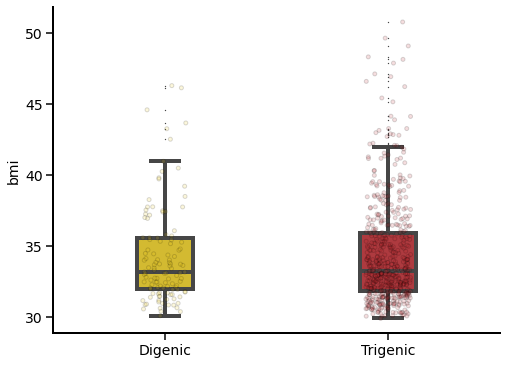

In [7]:
create_boxplot(phenos_df)

In [8]:
for test_vars in list(it.combinations(phenos_df.ctype.unique(), 2)):
    bmi_g1 = phenos_df.loc[phenos_df.ctype==test_vars[0], "bmi"]
    bmi_g2 = phenos_df.loc[phenos_df.ctype==test_vars[1], "bmi"]
    print(f"Testing {test_vars[0]} vs {test_vars[1]}")
    print(ttest_ind(bmi_g1, bmi_g2))
    print(kstest(bmi_g1, bmi_g2))

Testing Digenic vs Trigenic
Ttest_indResult(statistic=-0.25049665479768807, pvalue=0.8022794038212235)
KstestResult(statistic=0.04144555854542175, pvalue=0.9929269976935335)


In [9]:
bmi_g1.mean(), bmi_g2.mean()

(34.30394229691877, 34.39482537268932)

# Compare BMI of all individuals with digenic and trigenic combinations

In [10]:
def get_all_samples_with_combos(combo_df, wes_df):
    combo_2_sample_dict = dict()
    for uci in combo_df.unique_combo_id:
        genes = uci.split("_")
        cond = "(" + " & ".join([f"({c} == 1)" for c in genes]) + ")"
        combo_wes = wes_df.loc[wes_df.eval(cond)]
        combo_samples = set([str(i) for i in list(combo_wes.index)])
        combo_2_sample_dict[uci] = combo_samples
    return combo_2_sample_dict

In [11]:
combo_df = pd.concat(combo_dfs)
gene_cols = sum(list(map(lambda x: x.split("_"), combo_df.unique_combo_id.values)), [])
input_cols = ["Sample_Name"] + [f"Input_{gc}" for gc in gene_cols]
wes_df = pd.read_csv(wes_file, sep="\t", low_memory=False, usecols=input_cols, index_col="Sample_Name")
wes_df.columns = [c.replace("Input_", "") for c in wes_df.columns]

In [12]:
combo2_samples_dict = get_all_samples_with_combos(combo_dfs[0], wes_df)
combo3_samples_dict = get_all_samples_with_combos(combo_dfs[1], wes_df)

In [13]:
all_combo2_samples = set(sum([list(v) for v in combo2_samples_dict.values()], []))
all_combo3_samples = set(sum([list(v) for v in combo3_samples_dict.values()], []))
c2_cases_filtered = all_combo2_samples - all_combo3_samples
c3_cases_filtered = all_combo3_samples - all_combo2_samples

In [14]:
c2_phenos = phenotypes_df.loc[phenotypes_df.eid.isin(c2_cases_filtered)]
c3_phenos = phenotypes_df.loc[phenotypes_df.eid.isin(c3_cases_filtered)]
c2_phenos["ctype"] = "Digenic"
c3_phenos["ctype"] = "Trigenic"
phenos_df = pd.concat((c2_phenos, c3_phenos))

/tmp/ipykernel_1315166/430666136.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c2_phenos["ctype"] = "Digenic"
/tmp/ipykernel_1315166/430666136.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c3_phenos["ctype"] = "Trigenic"


In [15]:
for test_vars in list(it.combinations(phenos_df.ctype.unique(), 2)):
    bmi_g1 = phenos_df.loc[phenos_df.ctype==test_vars[0], "bmi"]
    bmi_g2 = phenos_df.loc[phenos_df.ctype==test_vars[1], "bmi"]
    print(f"Testing {test_vars[0]} vs {test_vars[1]}")
    print(ttest_ind(bmi_g1, bmi_g2))
    print(kstest(bmi_g1, bmi_g2))

Testing Digenic vs Trigenic
Ttest_indResult(statistic=-3.1968005295694164, pvalue=0.001428767410233789)
KstestResult(statistic=0.13852974828375286, pvalue=0.0012813247103828918)


(<Figure size 576x432 with 1 Axes>, <AxesSubplot:ylabel='bmi'>)

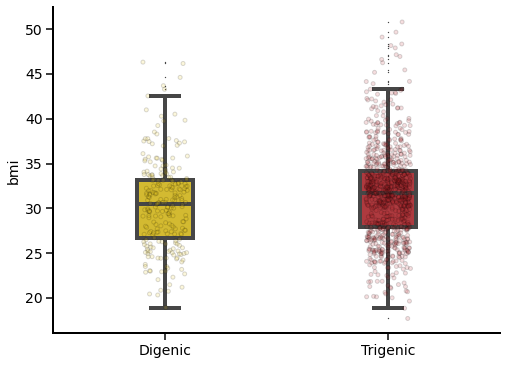

In [16]:
create_boxplot(phenos_df)